## Import the required libraries

In [1]:
%pip install contractions -q
%pip install nlpaug -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard library imports
from re import sub
from numpy import unique
from random import seed

# Third-party libraries
from contractions import fix
from pandas import DataFrame, read_csv, Series
from joblib import dump, load
import nltk
from nltk import download
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import nlpaug.augmenter.word as naw
from os import makedirs
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK downloads
download('punkt', quiet=True)
download('stopwords', quiet=True)
download('wordnet', quiet=True)
download('averaged_perceptron_tagger', quiet=True)

True

## Define the hyper-parameters

In [3]:
# Regular hyperparameters
lemmatize = True
stop_words = set(stopwords.words('english'))
max_features = 10000

# Fine-tuning hyperparameters
combine_fields = ['from', 'director', 'title']
threshold = 0.00
ngram_range = (1, 5)

# File paths
base = f'models/plot/{str(combine_fields)}_{int(threshold * 100)}_{str(ngram_range)}'
makedirs(base, exist_ok=True)

train_path = 'train.txt'
test_path = 'test_no_labels.txt'
output_path = 'results.txt'
label_encoder_path = f'{base}/label_encoder.plk'
vectorizer_path = f'{base}/vectorizer.plk'
svm_path = f'{base}/svm.plk'
mnb_path = f'{base}/mnb.plk'

## Load data

In [4]:
# Load data
def load_data():
    data = read_csv(train_path, sep='\t', names=['title', 'from', 'genre', 'director', 'plot'])
    return data

In [5]:
data = load_data()
data_copy = load_data()
data.head()

,title,from,genre,director,plot
0,Ela Cheppanu,Telugu,romance,Ramana,Sekhar (Tarun) is a graduate from IIM and work...
1,A Nightmare on Elm Street,American,horror,Samuel Bayer,Kris Fowles (Katie Cassidy) goes to the Spring...
2,American Gothic,American,horror,John Hough,Cynthia is traumatized by the death of her bab...
3,Gang,Bollywood,crime,Mazhar Khan,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Intimate Relations,British,drama,Charles Frank,Crisis in a middle-class family when the son f...


### Combine fields

In [6]:
# Combine fields
def combine():
    # Extract relevant columns (plot, combine_fields, genre)
    selected_fields = ['plot'] + combine_fields
    if 'genre' in data.columns:
        selected_fields.append('genre')
    combined_data = data[selected_fields].copy()

    # Handle missing values: drop rows with missing 'plot', fill missing combine_fields with ''
    combined_data.dropna(subset=['plot'], inplace=True)  # Ensure 'plot' is not NaN
    for field in combine_fields:
        combined_data[field] = combined_data[field].fillna('')  # Replace NaN in combine_fields with empty strings

    # Combine plot and other specified fields into a single feature
    combined_data['combined_text'] = combined_data['plot']
    for field in combine_fields:
        combined_data['combined_text'] += ' ' + combined_data[field]

    return combined_data

In [7]:
data = combine()
data.head()

,plot,from,director,title,genre,combined_text
0,Sekhar (Tarun) is a graduate from IIM and work...,Telugu,Ramana,Ela Cheppanu,romance,Sekhar (Tarun) is a graduate from IIM and work...
1,Kris Fowles (Katie Cassidy) goes to the Spring...,American,Samuel Bayer,A Nightmare on Elm Street,horror,Kris Fowles (Katie Cassidy) goes to the Spring...
2,Cynthia is traumatized by the death of her bab...,American,John Hough,American Gothic,horror,Cynthia is traumatized by the death of her bab...
3,"Four friends, Gangu (Jackie Shroff), Abdul (Na...",Bollywood,Mazhar Khan,Gang,crime,"Four friends, Gangu (Jackie Shroff), Abdul (Na..."
4,Crisis in a middle-class family when the son f...,British,Charles Frank,Intimate Relations,drama,Crisis in a middle-class family when the son f...


## Split data into training and test sets

In [8]:
# Split data into training and test sets
'''def split_data():
    X = data['combined_text']
    y = data['genre']
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)
    return X_train, X_test, y_train, y_test, label_encoder'''

def split_data():
    X = data['combined_text']  # Assuming 'combined_text' is your features (plots)
    y = data['genre']          # Assuming 'genre' is your target variable
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Perform train/test split while returning the indices of the test set
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y_encoded, data.index, test_size=0.1, random_state=42, stratify=y_encoded
    )

    return X_train, X_test, y_train, y_test, label_encoder, test_indices

In [9]:
X_train, X_test, y_train, y_test, label_encoder,test_indices = split_data()
label_encoder.classes_

array(['action', 'animation', 'comedy', 'crime', 'drama', 'horror',
       'romance', 'sci-fi', 'western'], dtype=object)

In [10]:
# Save label encoder
dump(label_encoder, label_encoder_path)

["models/plot/['from', 'director', 'title']_0_(1, 5)/label_encoder.plk"]

## Data augmentation

In [11]:
data = DataFrame({'combined_text': X_train, 'genre': y_train})

# Initialize the seed
seed(42)

# Initialize the SynonymAugmenter
aug = naw.SynonymAug(aug_src='wordnet', aug_max=30)
augments_encoded = label_encoder.transform(['sci-fi', 'animation', 'crime'])

# Define augmentation settings for each genre
augmentation_config = {
    augments_encoded[0]: 3,    # Augment 3 times
    augments_encoded[1]: 1, # Augment 1 time
    augments_encoded[2]: 1,     # Augment 1 time
}

# Not augmenting the remaining genre
for genre in unique(y_train):
    if genre not in augmentation_config:
        augmentation_config[genre] = 0  # Default to augmenting once

# List to hold original and augmented text along with their genres
all_texts = []
all_genres = []

# Loop through each genre and apply the augmentation as needed
for genre, n in augmentation_config.items():
    genre_data = data[data['genre'] == genre].copy()

    # Add original texts and genres to the lists
    all_texts.extend(genre_data['combined_text'].tolist())
    all_genres.extend([genre] * len(genre_data))  # Repeat the genre for the number of rows

    # Apply augmentation if n > 0
    if n > 0:
        augmented_texts = genre_data['combined_text'].apply(lambda x: aug.augment(x, n=n))
        # Flatten the lists of augmented texts
        augmented_texts = augmented_texts.explode().tolist()
        # Add augmented texts and genres to the lists
        all_texts.extend(augmented_texts)
        all_genres.extend([genre] * len(augmented_texts))  # Repeat the genre for the number of augmented rows

# Create a DataFrame with the text and genre columns
data = DataFrame({'text': all_texts, 'genre': all_genres})

data.head()

,text,genre
0,"In the near future,[3] Lunar Industries has ma...",7
1,"The plot follows a disgruntled scientist who, ...",7
2,"Set inside a Quake like video game, one of the...",7
3,Dr. Maxwell Kirshner (Ray Milland) arrives at ...,7
4,"On November 5, 1975 in Snowflake, Arizona, log...",7


## Clean the text

In [12]:
# Clean the text
def clean_text(text):
    # Check if the text is a non-empty string
    if not isinstance(text, str) or not text.strip():
        return ''

    # Skip applying contractions if the text is too long or complex
    if len(text) > 500:  # Threshold to skip contraction expansion for long texts
        return text

    # Try expanding contractions safely
    try:
        text = fix(text)
    except Exception as e:
        print(f"Error expanding contractions: {e}, for text: {text[:100]}...")  # Only print the first 100 characters
        return text  # Return the original text if expansion fails

    # Remove special characters and digits
    text = sub(r'[^a-zA-Z\s]', '', text)

    return text

## Function to convert nltk POS tag to wordnet POS tag

In [13]:
# Function to convert nltk POS tag to wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

## Lemmatize the text

In [14]:
# Function to lemmatize text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())
    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Perform POS tagging
    tagged_tokens = nltk.pos_tag(tokens)
    # Lemmatize each token using the POS tag
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return ' '.join(lemmatized_tokens)

In [15]:
# Genre words to remove from the data
genres = ['horror', 'crime', 'action', 'comedy', 'animation', 'western']

## Preprocess the data

In [16]:
# Preprocess the data without stop words
def preprocess_data(df):
    # Clean the text
    df['text'] = df['text'].apply(clean_text)
    # Apply lemmatization if specified
    if lemmatize:
        df['text'] = df['text'].apply(lemmatize_text)

    return df

In [17]:
# Preprocess train data
data = preprocess_data(data)
data.head()

,text,genre
0,in the near future lunar industry have make a ...,7
1,the plot follow a disgruntled scientist who ha...,7
2,set inside a quake like video game one of the ...,7
3,maxwell kirshner ray milland arrive at a mansi...,7
4,on november in snowflake arizona logger travis...,7


In [18]:
# Preprocess test data
data_test = DataFrame({'text': X_test})
X_test = preprocess_data(data_test)['text']
y_train = data['genre']

## Stopwords filtering

In [19]:
X_train = data['text']
X_train_series = Series(X_train)

# CountVectorizer to create a document-term matrix for stop words
vectorizer = CountVectorizer(vocabulary=stop_words, binary=True)  # Count presence
X = vectorizer.fit_transform(X_train_series)  # Transform the title-plot feature

# Compute document frequencies
doc_freq = X.sum(axis=0) / X.shape[0]  # Fraction of documents (observations) containing each stop word

# Sort stop words by document frequency.
stop_word_df = DataFrame({
    'stop_word': vectorizer.get_feature_names_out(),
    'doc_frequency': doc_freq.A1
}).sort_values(by='doc_frequency', ascending=False)

# Set a threshold for significant stop words
def threshold_stop_word_df():
  return stop_word_df[stop_word_df['doc_frequency'] >= threshold]

stop_words_filtered = threshold_stop_word_df()['stop_word'].tolist()
stop_words_filtered += genres

In [20]:
# Feature extraction function
def extract_features():
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        sublinear_tf=True,
        norm='l2',
        stop_words=stop_words_filtered
    )
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, vectorizer


X_train_tfidf, X_test_tfidf, vectorizer = extract_features()

In [21]:
# Save vectorizers
dump(vectorizer, vectorizer_path)

["models/plot/['from', 'director', 'title']_0_(1, 5)/vectorizer.plk"]

## Train SVM with hyperparameter tuning

In [22]:
def train_svm():
    '''param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'class_weight': ['balanced', None]
    }
    grid_search = GridSearchCV(SVC(random_state = 42), param_grid, cv=5, n_jobs=-1, scoring="accuracy")
    grid_search.fit(X_train_tfidf, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best SVM Parameters: {grid_search.best_params_}")
    '''

    model = SVC(kernel='sigmoid', C=1.0, class_weight=None, random_state = 42)
    model.fit(X_train_tfidf, y_train)
    
    return model

In [23]:
# SVM training
svm_tfidf = train_svm()

In [24]:
# Save SVM models
dump(svm_tfidf, svm_path)

["models/plot/['from', 'director', 'title']_0_(1, 5)/svm.plk"]

## Train Multinomial NB with hyperparameter tuning

In [25]:
# Train Multinomial NB with hyperparameter tuning
def train_MultinomialNB():
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Smoothing parameter
        'fit_prior': [True, False],           # Whether to learn class prior probabilities
    }

    grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, n_jobs=-1, scoring="accuracy")
    grid_search.fit(X_train_tfidf, y_train)
    best_model = grid_search.best_estimator_
    
    print(f"Best Multinomial NB Parameters: {grid_search.best_params_}")

    return best_model

In [26]:
# MultinomialNB training
MultinomialNB_tfidf = train_MultinomialNB()

Best Multinomial NB Parameters: {'alpha': 0.1, 'fit_prior': False}


In [27]:
# Save MultinomialNB models
dump(MultinomialNB_tfidf, mnb_path)

["models/plot/['from', 'director', 'title']_0_(1, 5)/mnb.plk"]

## Evaluate the model

In [28]:
# Evaluate the model
def evaluate_model(model):
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, predictions)
    return accuracy, report, cm
    
def plot_cm(cm, label_encoder, cm_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.T, annot=True, fmt='d', cmap='viridis', cbar=False,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig(cm_path)

# def evaluate_model(model):
#     global X_test_tfidf, y_test, label_encoder, data, test_indices

#     # Step 1: Get model predictions
#     predictions = model.predict(X_test_tfidf)

#     # Step 2: Compute accuracy, classification report, and confusion matrix
#     accuracy = accuracy_score(y_test, predictions)
#     report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
#     cm = confusion_matrix(y_test, predictions)

#     # Step 3: Decode the true and predicted labels from their encoded form
#     y_test_labels = label_encoder.inverse_transform(y_test)
#     predictions_labels = label_encoder.inverse_transform(predictions)

#     # Step 4: Subset `data` to only include the test set using `test_indices`

#     data_test = data_copy.loc[test_indices]  # Use test_indices to subset data

#     # Step 5: Extract a single example for misclassifications in the specified genre pairs
#     def get_misclassified_example(true_label, predicted_label):
#         # Filter rows where the true label is misclassified as the predicted label
#         mask = (y_test_labels == true_label) & (predictions_labels == predicted_label)
#         misclassified_examples = data_test[mask]['plot']  # Use data_test here
#         if not misclassified_examples.empty:
#             return misclassified_examples.iloc[0]  # Return the first example
#         else:
#             return None  # Return None if no example is found

#     # Step 6: Collect one misclassified example for each genre pair
#     drama_romance_example = get_misclassified_example('drama', 'romance')
#     romance_drama_example = get_misclassified_example('romance', 'drama')
#     action_sci_fi_example = get_misclassified_example('action', 'sci-fi')
#     sci_fi_action_example = get_misclassified_example('sci-fi', 'action')
#     comedy_drama_example = get_misclassified_example('comedy', 'drama')
#     drama_comedy_example = get_misclassified_example('drama', 'comedy')

#     # Step 7: Return the evaluation results and a single misclassified example for each pair
#     return {
#         "accuracy": accuracy,
#         "report": report,
#         "confusion_matrix": cm,
#         "misclassified_examples": {
#             "Drama -> Romance": drama_romance_example,
#             "Romance -> Drama": romance_drama_example,
#             "Action -> Sci-Fi": action_sci_fi_example,
#             "Sci-Fi -> Action": sci_fi_action_example,
#             "Comedy -> Drama": comedy_drama_example,
#             "Drama -> Comedy": drama_comedy_example,
#         }
#     }

In [29]:
accuracy_svm, report_svm, cm_svm = evaluate_model(svm_tfidf)
print(f"Accuracy SVM_tfidf: {accuracy_svm * 100:.2f}%")

# accuracy_svm = result["accuracy"]

# drama_romance = result["misclassified_examples"]["Drama -> Romance"]
# romance_drama = result["misclassified_examples"]["Romance -> Drama"]

# action_scifi = result["misclassified_examples"]["Action -> Sci-Fi"]
# scifi_action = result["misclassified_examples"][ "Sci-Fi -> Action"]

# comedy_drama = result["misclassified_examples"]["Comedy -> Drama"]
# drama_comedy = result["misclassified_examples"]["Drama -> Comedy"]

# print(f"Should be Drama but was Romance \n {drama_romance}")
# print(f"Should be Romance but was Drama \n {romance_drama}")

# print(f"Should be Action but was Sci-Fi \n {action_scifi}")
# print(f"Should be Sci-Fi but was Action \n {scifi_action}")

# print(f"Should be Comedy but was Drama \n {comedy_drama}")
# print(f"Should be Drama but was Comedy \n {drama_comedy}")


accuracy_mnb, report_mnb, cm_mnb = evaluate_model(MultinomialNB_tfidf)
print(f"Accuracy MultinomialNB_tfidf: {accuracy_mnb * 100:.2f}%")

Accuracy SVM_tfidf: 70.31%
Accuracy MultinomialNB_tfidf: 64.97%


### Determine the best model

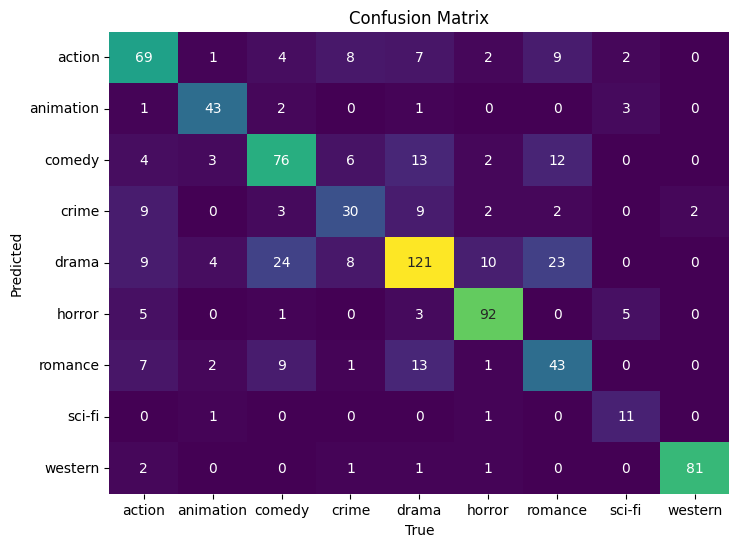

In [30]:
# Determine the best model
if accuracy_svm >= accuracy_mnb:
    best_model_path = svm_path
    best_report = report_svm
    report_path = f'{base}/report_svm.txt'
    best_cm = cm_svm
    cm_path = f'{base}/cm_svm.png'
else:
    best_model_path = mnb_path
    best_report = report_mnb
    report_path = f'{base}/report_mnb.txt'
    best_cm = cm_mnb
    cm_path = f'{base}/cm_mnb.png'

# Save classification report
with open(report_path, 'w') as f:
    f.write(str(best_report))

# Save confusion matrix
cm_df = DataFrame(best_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plot_cm(best_cm, label_encoder, cm_path)

## Load the model and vectorizer

In [31]:
# Load a certain model
def load_model(model_path, vectorizer_path, label_encoder_path):
    model = load(model_path)
    vectorizer = load(vectorizer_path)
    label_encoder = load(label_encoder_path)
    return model, vectorizer, label_encoder

In [32]:
# Load the best model
model, vectorizer, label_encoder = load_model(best_model_path, vectorizer_path, label_encoder_path)

## Predict the genre for new movie plots

In [33]:
# Combine fields
def combine_test(data_test):
    # Extract relevant columns (plot, combine_fields, genre)
    selected_fields = ['plot'] + combine_fields
    combined_data = data_test[selected_fields].copy()

    # Handle missing values: drop rows with missing 'plot', fill missing combine_fields with ''
    combined_data.dropna(subset=['plot'], inplace=True)  # Ensure 'plot' is not NaN
    for field in combine_fields:
        combined_data[field] = combined_data[field].fillna('')  # Replace NaN in combine_fields with empty strings

    # Combine plot and other specified fields into a single feature
    combined_data['text'] = combined_data['plot']
    for field in combine_fields:
        combined_data['text'] += ' ' + combined_data[field]

    return combined_data

In [34]:
# Predict the genre of the test data
def predict_genre():
    data_test = read_csv(test_path, sep='\t', names=['title', 'from', 'director', 'plot'])
    data_test = combine_test(data_test)
    data_test = preprocess_data(data_test)
    plots = data_test['text']
    plot_vectors = vectorizer.transform(plots)
    predicted_genres_encoded = model.predict(plot_vectors)
    predicted_genres = label_encoder.inverse_transform(predicted_genres_encoded)

    # Save the results to a file
    with open(output_path, 'w') as f:
        for genre in predicted_genres:
            f.write(f"{genre}\n")

In [35]:
predict_genre()